<a href="https://colab.research.google.com/github/ArchisKulkarni002/RansomwareMLProject/blob/gpu/Ransomware_Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [73]:
!pip install holoviews datashader pandas bokeh
!pip install cupy-cuda12x  # Install CuPy for CUDA 12.2
# !pip install --extra-index-url=https://pypi.nvidia.com cudf-cu12
!pip install cudf-cu12

In [74]:
!nvidia-smi


Thu Nov 14 19:27:24 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0              32W /  70W |   4733MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

CuPy version: 12.2.0


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
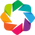

The cudf.pandas extension is already loaded. To reload it, use:
  %reload_ext cudf.pandas


In [48]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec  as gridspec
import matplotlib.ticker as mticker
import warnings
from IPython.display import display, HTML
import ipaddress
import holoviews as hv
from holoviews.operation.datashader import datashade
import colorcet as cc  # Provides color palettes for better visibility
from bokeh.models import ColorBar, LinearColorMapper
import datashader as ds
import cupy as cp
# import cudf

# Test CuPy
print("CuPy version:", cp.__version__)
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

hv.extension('bokeh')

%load_ext cudf.pandas
# Suppress all warnings
warnings.simplefilter("ignore")
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_seq_items', None)
pd.set_option('display.expand_frame_repr', False)

In [49]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
data_path = '/content/drive/MyDrive/Android_Ransomeware.csv'
ransomware_df = pd.read_csv(data_path)

#EDA and PreProcessing

In [51]:
#defining color palettes
ransomware_palette = sns.color_palette("Set1", 11)
protocol_palette =  {'Reserved': sns.color_palette("muted")[1],  # muted orange
                    'TCP': sns.color_palette("muted")[0],       # muted blue
                    'UDP': sns.color_palette("muted")[2]}

In [52]:
ransomware_df['Label'].unique().tolist()

# for label, color in ransomware_palette.items():
#   print(f"{label}: {color}")

['Benign',
 'Charger',
 'Jisut',
 'Koler',
 'Lockerpin',
 'Pletor',
 'PornDroid',
 'RansomBO',
 'Simplocker',
 'SVpeng',
 'WannaLocker']

In [53]:
ransomware_df.columns = ransomware_df.columns.str.strip()

In [54]:
print(ransomware_df.head(5))

   Index                                 Flow ID    Source IP  Source Port  Destination IP  Destination Port  Protocol         Timestamp  Flow Duration  Total Fwd Packets  Total Backward Packets  Total Length of Fwd Packets  Total Length of Bwd Packets  Fwd Packet Length Max  Fwd Packet Length Min  Fwd Packet Length Mean  Fwd Packet Length Std  Bwd Packet Length Max  Bwd Packet Length Min  Bwd Packet Length Mean  Bwd Packet Length Std  Bwd Avg Bytes/Bulk  Bwd Avg Packets/Bulk  Bwd Avg Bulk Rate  Subflow Fwd Packets  Subflow Fwd Bytes  Subflow Bwd Packets  Subflow Bwd Bytes  Init_Win_bytes_forward  Init_Win_bytes_backward  act_data_pkt_fwd  min_seg_size_forward  Active Mean  Active Std  Active Max  Active Min  Idle Mean  Idle Std  Idle Max  Idle Min   Label
0      0   172.217.2.174-10.42.0.211-443-51023-6  10.42.0.211        51023   172.217.2.174               443         6  16-06-2017 03:55         151054                  6                       8                         1076          

In [55]:
#printing shape of ransomware df
df_row_count, df_column_count = ransomware_df.shape
print("rows = ", df_row_count, " cols = ", df_column_count)

rows =  392034  cols =  86


In [56]:
def summarize_dataframe(df):
    # Initialize an empty list to store summary data for each column
    summary_data = []

    # Loop through each column to get dtype, null count, distinct count, and additional statistics
    for col in df.columns:
        dtype = df[col].dtype
        null_count = df[col].isnull().sum()
        distinct_count = df[col].nunique()

        # Dictionary to store summary data for this column
        col_summary = {
            'Column': col.strip(),
            'Data Type': dtype,
            'Total Count': df_row_count,
            'Total Distinct': distinct_count,
            'Null Count': null_count

        }

        # Calculate stats based on data type
        if pd.api.types.is_numeric_dtype(df[col]):
            col_summary['Mean'] = df[col].mean()
            col_summary['Median'] = df[col].median()
            col_summary['Max'] = df[col].max()
            col_summary['Min'] = df[col].min()
            col_summary['Std_Dev'] = df[col].std()
        elif pd.api.types.is_object_dtype(df[col]):
            col_summary['Mode'] = df[col].mode().iloc[0] if not df[col].mode().empty else None
        else:
            col_summary['Mean'] = col_summary['Median'] = col_summary['Max'] = col_summary['Min'] = col_summary['Std_Dev'] = None
            col_summary['Mode'] = None

        # Append the column summary to the list
        summary_data.append(col_summary)

    return summary_data





In [57]:
summary_df = pd.DataFrame(summarize_dataframe(ransomware_df))

display(HTML(summary_df.to_html(max_rows=100, max_cols=None)))

,Column,Data Type,Total Count,Total Distinct,Null Count,Mean,Median,Max,Min,Std_Dev,Mode
0,Index,int64,392034,8699,0,1.872127e+03,1637.000000,8.698000e+03,0.000000e+00,1.441683e+03,NaN
1,Flow ID,object,392034,203556,0,NaN,NaN,NaN,NaN,NaN,8.0.6.4-8.6.0.1-0-0-0
2,Source IP,object,392034,2504,0,NaN,NaN,NaN,NaN,NaN,10.42.0.211
3,Source Port,int64,392034,52913,0,3.870163e+04,43469.000000,6.553400e+04,0.000000e+00,1.860661e+04,NaN
4,Destination IP,object,392034,5056,0,NaN,NaN,NaN,NaN,NaN,10.42.0.1
5,Destination Port,int64,392034,21942,0,5.941135e+03,443.000000,6.548700e+04,0.000000e+00,1.531961e+04,NaN
6,Protocol,int64,392034,3,0,8.373332e+00,6.000000,1.700000e+01,0.000000e+00,4.602725e+00,NaN
7,Timestamp,object,392034,4321,0,NaN,NaN,NaN,NaN,NaN,28-08-2017 12:10
8,Flow Duration,int64,392034,298031,0,1.067684e+07,515256.000000,1.199997e+08,1.000000e+00,2.197262e+07,NaN
9,Total Fwd Packets,int64,392034,605,0,7.078121e+00,2.000000,3.632000e+03,1.000000e+00,3.343450e+01,NaN


In [58]:
#Dropping the index columns
processed_ransomware_df = ransomware_df.drop(['Index', 'Flow ID' ], axis=1, inplace=False)

In [59]:
#columnns with only single value
single_valued_cols = summary_df.loc[summary_df['Total Distinct'] == 1, 'Column'].tolist()
print(single_valued_cols)

#Dropping the single valued columns
processed_ransomware_df = processed_ransomware_df.drop(single_valued_cols, axis=1, inplace=False)
summary_df = pd.DataFrame(summarize_dataframe(processed_ransomware_df))

display(HTML(summary_df.to_html(max_rows=100, max_cols=None)))

['Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'RST Flag Count', 'CWE Flag Count', 'ECE Flag Count', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']


,Column,Data Type,Total Count,Total Distinct,Null Count,Mode,Mean,Median,Max,Min,Std_Dev
0,Source IP,object,392034,2504,0,10.42.0.211,NaN,NaN,NaN,NaN,NaN
1,Source Port,int64,392034,52913,0,NaN,3.870163e+04,43469.000000,6.553400e+04,0.000000e+00,1.860661e+04
2,Destination IP,object,392034,5056,0,10.42.0.1,NaN,NaN,NaN,NaN,NaN
3,Destination Port,int64,392034,21942,0,NaN,5.941135e+03,443.000000,6.548700e+04,0.000000e+00,1.531961e+04
4,Protocol,int64,392034,3,0,NaN,8.373332e+00,6.000000,1.700000e+01,0.000000e+00,4.602725e+00
5,Timestamp,object,392034,4321,0,28-08-2017 12:10,NaN,NaN,NaN,NaN,NaN
6,Flow Duration,int64,392034,298031,0,NaN,1.067684e+07,515256.000000,1.199997e+08,1.000000e+00,2.197262e+07
7,Total Fwd Packets,int64,392034,605,0,NaN,7.078121e+00,2.000000,3.632000e+03,1.000000e+00,3.343450e+01
8,Total Backward Packets,int64,392034,943,0,NaN,8.711813e+00,1.000000,1.282000e+04,0.000000e+00,8.094987e+01
9,Total Length of Fwd Packets,int64,392034,10711,0,NaN,8.844412e+02,31.000000,4.309688e+06,0.000000e+00,1.662189e+04


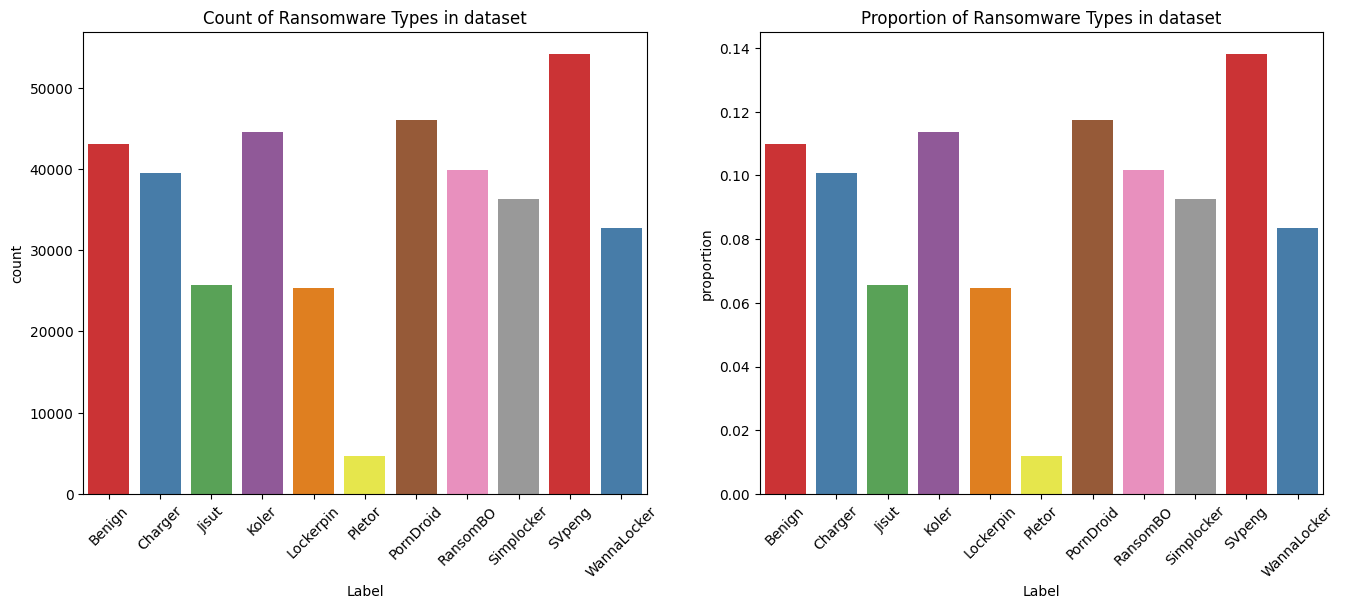

In [60]:
# plt.figure(figsize=(8, 6))
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.countplot(data=processed_ransomware_df, x='Label', ax = axes[0], palette=ransomware_palette)
axes[0].set_title('Count of Ransomware Types in dataset')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)

sns.countplot(data=processed_ransomware_df, x='Label', ax = axes[1], stat='proportion', palette=ransomware_palette)
axes[1].set_title('Proportion of Ransomware Types in dataset')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
plt.show()

In [61]:
def is_private_ip(ip):
    try:
      ip_obj = ipaddress.ip_address(ip)

      if ip_obj.is_private:
          return 'private'
      elif ip_obj.is_loopback:
          return 'loopback'
      elif ip_obj.is_link_local:
          return 'link_local'
      elif ip_obj.is_multicast:
          return 'multicast'
      else:
          return 'public'
    except ValueError:
        return None

processed_ransomware_df['Source_IP_type'] = processed_ransomware_df['Source IP'].apply(is_private_ip)
processed_ransomware_df['Destination_IP_type'] = processed_ransomware_df['Destination IP'].apply(is_private_ip)



ip_type_summary_df = pd.DataFrame(summarize_dataframe(processed_ransomware_df[['Source_IP_type', 'Destination_IP_type']]))
display(HTML(ip_type_summary_df.to_html(max_rows=100, max_cols=None)))

,Column,Data Type,Total Count,Total Distinct,Null Count,Mode
0,Source_IP_type,object,392034,2,0,private
1,Destination_IP_type,object,392034,3,0,public


In [62]:
# Drop the source IP and destination IP
processed_ransomware_df.drop('Source IP' , axis=1, inplace=True)
processed_ransomware_df.drop('Destination IP' , axis=1, inplace=True)

print(processed_ransomware_df.columns)



Index(['Source Port', 'Destination Port', 'Protocol', 'Timestamp',
       'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets',
       'Total Length of Fwd Packets', 'Total Length of Bwd Packets',
       'Fwd Packet Length Max', 'Fwd Packet Length Min',
       'Fwd Packet Length Mean', 'Fwd Packet Length Std',
       'Bwd Packet Length Max', 'Bwd Packet Length Min',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s',
       'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags',
       'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s',
       'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length',
       'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance',
       'FIN Flag Count', 'SYN Flag Count', 'PSH Flag Co

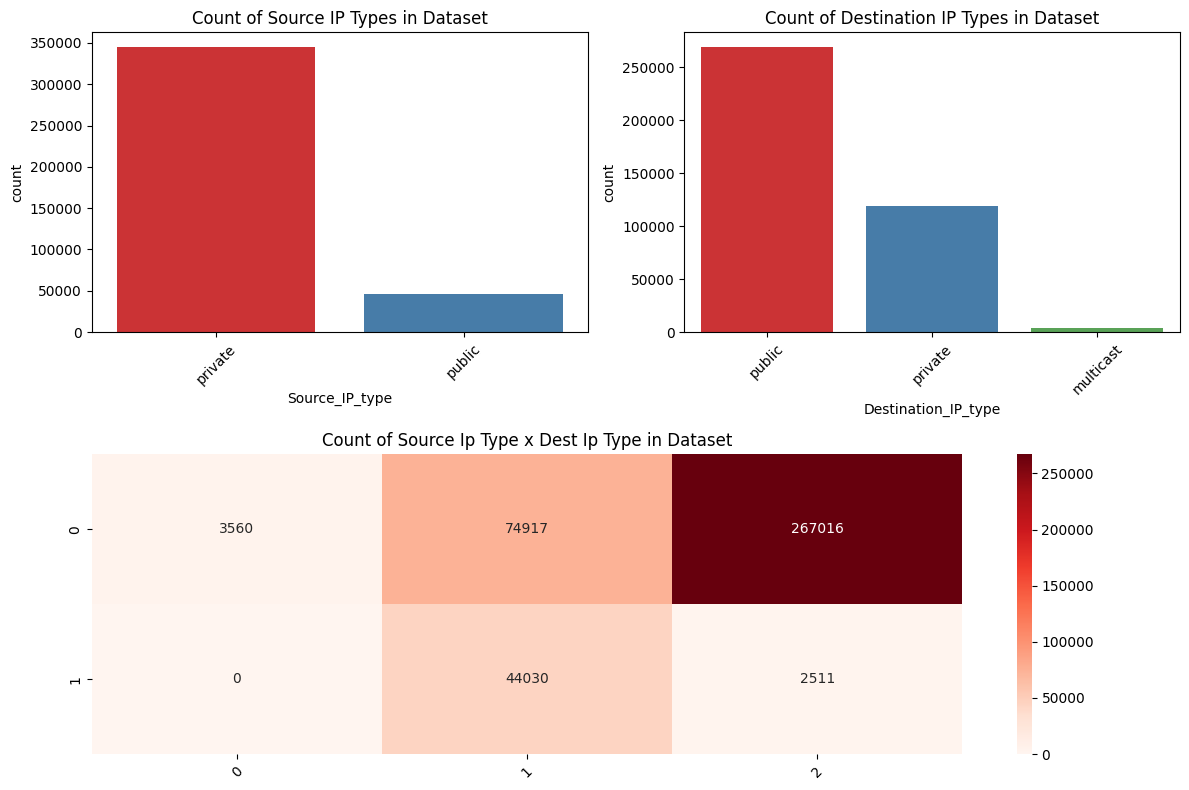

In [63]:
# Define figure and gridspec layout
fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(2, 2, figure=fig)

# Top-left plot
ax1 = fig.add_subplot(gs[0, 0])
sns.countplot(data=processed_ransomware_df, x='Source_IP_type', ax=ax1, palette=ransomware_palette)
ax1.set_title('Count of Source IP Types in Dataset')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)

# Top-right plot
ax2 = fig.add_subplot(gs[0, 1])
sns.countplot(data=processed_ransomware_df, x='Destination_IP_type', ax=ax2, palette=ransomware_palette)
ax2.set_title('Count of Destination IP Types in Dataset')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)

# Bottom-wide plot, spanning both columns
ax3 = fig.add_subplot(gs[1, :])
contingency_table = pd.crosstab(processed_ransomware_df['Source_IP_type'], processed_ransomware_df['Destination_IP_type'])
sns.heatmap(contingency_table, annot=True, fmt='d', cmap='Reds', ax=ax3)

ax3.set_title('Count of Source Ip Type x Dest Ip Type in Dataset')
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45)

# Adjust layout for readability
plt.tight_layout()
plt.show()

In [64]:
def chi2_calculator( col1, col2):
  # Calculate the Chi-square statistic
    chi2 = 0
    contingency_table = pd.crosstab(col1, col2)


    n = contingency_table.sum().sum()  # Total number of observations

    # Calculate expected frequencies
    row_totals = contingency_table.sum(axis=1).values.reshape(-1, 1)
    col_totals = contingency_table.sum(axis=0).values.reshape(1, -1)
    expected = (row_totals @ col_totals) / n  # Expected frequency for each cell



    # Compute Chi-square by summing (Observed - Expected)^2 / Expected
    chi2 = ((contingency_table - expected) ** 2 / expected).to_numpy().sum()

    return chi2, (row_totals.shape[0]-1)*(col_totals.shape[1]-1) # returns chi2, degree for freedom (r-1)*(c-1)

def chi2_calculator_cp( col1, col2):
  # Calculate the Chi-square statistic
    # Create a contingency table using pandas (CPU-based)
    contingency_table = pd.crosstab(col1, col2)

    n = contingency_table.sum().sum()  # Total number of observations

    # Calculate expected frequencies using cudf and numpy (convert numpy arrays to cupy)
    row_totals = cp.array(contingency_table.sum(axis=1).values.reshape(-1, 1))  # Convert to cupy array
    col_totals = cp.array(contingency_table.sum(axis=0).values.reshape(1, -1))  # Convert to cupy array
    expected = (row_totals @ col_totals) / n  # Expected frequency for each cell, now done on GPU with cupy

    # Compute Chi-square by summing (Observed - Expected)^2 / Expected
    chi2 = cp.sum((cp.array(contingency_table.values) - expected) ** 2 / expected)

    # Degrees of freedom (r-1)*(c-1)
    df = (row_totals.shape[0] - 1) * (col_totals.shape[1] - 1)

    return chi2, df# returns chi2, degree for freedom (r-1)*(c-1)

#Corrected Cramers https://stats.lse.ac.uk/bergsma/pdf/cramerV3.pdf
def cramers_v(col1, col2):

    # Step 1: Create a contingency table
    contingency_table = pd.crosstab(col1, col2)
    n = contingency_table.sum().sum()
    # Step 2: Calculate the Chi-square statistic
    chi2, chi_df = chi2_calculator_cp(col1, col2)
    phi2 = chi2 / n

    r, c = contingency_table.shape
    #corrected phi2
    phi2 = max(0, phi2 - ((c-1)*(r-1)/(n-1)))

    r = r - ((r -1)**2/(n-1))
    c = c - ((c -1)**2/(n-1))


    # Step 3: Calculate Cramér's V

    cramers_v = np.sqrt(phi2 / (min(r-1, c-1)))

    return cramers_v

In [65]:
#cramer v for source port and label

sample_df = processed_ransomware_df[['Source Port', 'Label']]  # Adjust 'n' as needed
cvalue_s_port_label = cramers_v(sample_df['Source Port'], sample_df['Label'])
print("cramers v  for source_port and label = ", cvalue_s_port_label)

#cramers v for destination port and label
sample_df = processed_ransomware_df[['Destination Port', 'Label']]  # Adjust 'n' as needed
cvalue_d_port_label = cramers_v(sample_df['Destination Port'], sample_df['Label'])
print("cramers v  for Destination port and label = ", cvalue_d_port_label)


#cramers v for source and destination port pair v label
sample_df = pd.DataFrame()

sample_df['Source_Destination_port'] = processed_ransomware_df['Source Port'].astype(str) + '-' + processed_ransomware_df['Destination Port'].astype(str)
sample_df['Label'] = processed_ransomware_df['Label']
cvalue_s_d_port_label = cramers_v(sample_df['Source_Destination_port'], sample_df['Label'] )
print("cramers v  for Source-Destination port and label = ", cvalue_s_d_port_label)

#cramer v for source and destination port // Computationally too heavy

# sample_df = processed_ransomware_df[['Destination Port', 'Source Port']].sample(50000, random_state=42)
# # contingency_table = pd.crosstab(sample_df['col1'], sample_df['col2'])
# cvalue_sd_port_label = cramers_v(sample_df['Destination Port'], sample_df['Source Port'])
# print("cramers v  for Destination port and Source Port = ", cvalue_sd_port_label)

cramers v  for source_port and label =  0.28716033347813025
cramers v  for Destination port and label =  0.19759029544301265
cramers v  for Source-Destination port and label =  0.4184567528908159


### Observation

- Source Port and Ransomware Type has ~0.29 association; **Weak to Moderate** association

- Destination Port and Ransomware Type has ~0.19 association: **Weak** association

- Source-Destination Port Pair and Ransomware Type has ~0.42 assocition: **Moderate** associtation

Based on this we cannot drop the port table, as they have moderate assocation with ransomware type , when taken pair wise,  we may need further analysis, to drop the columns.

In [66]:
protocol_mapping = {
    0: 'Reserved',
    1: 'ICMP',              # Internet Control Message Protocol
    6: 'TCP',               # Transmission Control Protocol
    17: 'UDP',              # User Datagram Protocol
}

# Map protocol numbers to protocol names
processed_ransomware_df['Protocol'] = processed_ransomware_df['Protocol'].map(protocol_mapping)

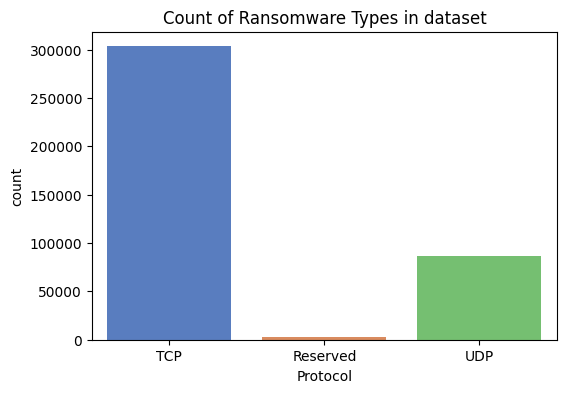

In [67]:
plt.figure(figsize=(6, 4))
# fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.countplot(data=processed_ransomware_df, x='Protocol', palette=protocol_palette)
plt.title('Count of Ransomware Types in dataset')
# axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
plt.show()

<Figure size 1200x800 with 0 Axes>

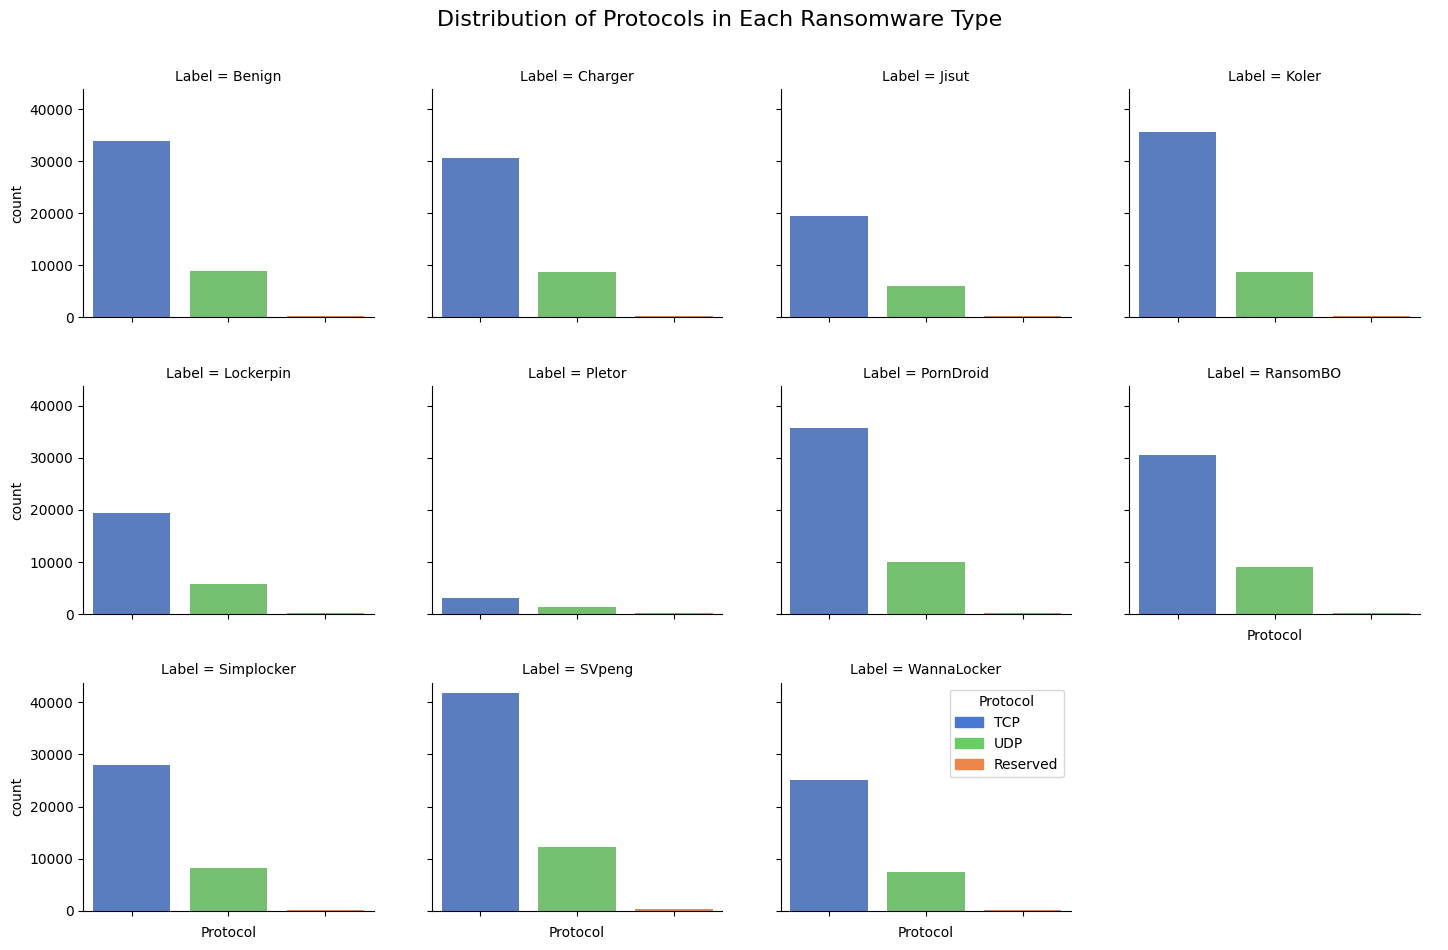

In [68]:
plt.figure(figsize=(12, 8))
grid = sns.FacetGrid(data=processed_ransomware_df, col='Label',height=3, aspect=1.2, col_wrap=4)

grid.map(sns.countplot, 'Protocol', order=['TCP', 'UDP', 'Reserved'], palette = protocol_palette)

# # grid.fig.suptitle('Count of Each Weekday in Each Cluster', y=1.05, fontsize=16

for i, ax in enumerate(grid.axes.flat):
  if i>=3:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# Adjust layout to avoid overlap
plt.tight_layout()
grid.fig.subplots_adjust(hspace=0.3, wspace=0.2)
grid.fig.suptitle('Distribution of Protocols in Each Ransomware Type', y=1.05, fontsize=16)
grid.add_legend()
import matplotlib.patches as mpatches
legend_handles = [
  mpatches.Patch(color=sns.color_palette("muted")[0], label='TCP'),      # muted blue
    mpatches.Patch(color=sns.color_palette("muted")[2], label='UDP'),      # muted green
    mpatches.Patch(color=sns.color_palette("muted")[1], label='Reserved')  # muted orange

]

# Add the custom legend to the grid
plt.legend(handles=legend_handles, title="Protocol", loc="upper right")
# Show the plot
plt.show()

['Fwd PSH Flags', 'FIN Flag Count', 'SYN Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count']


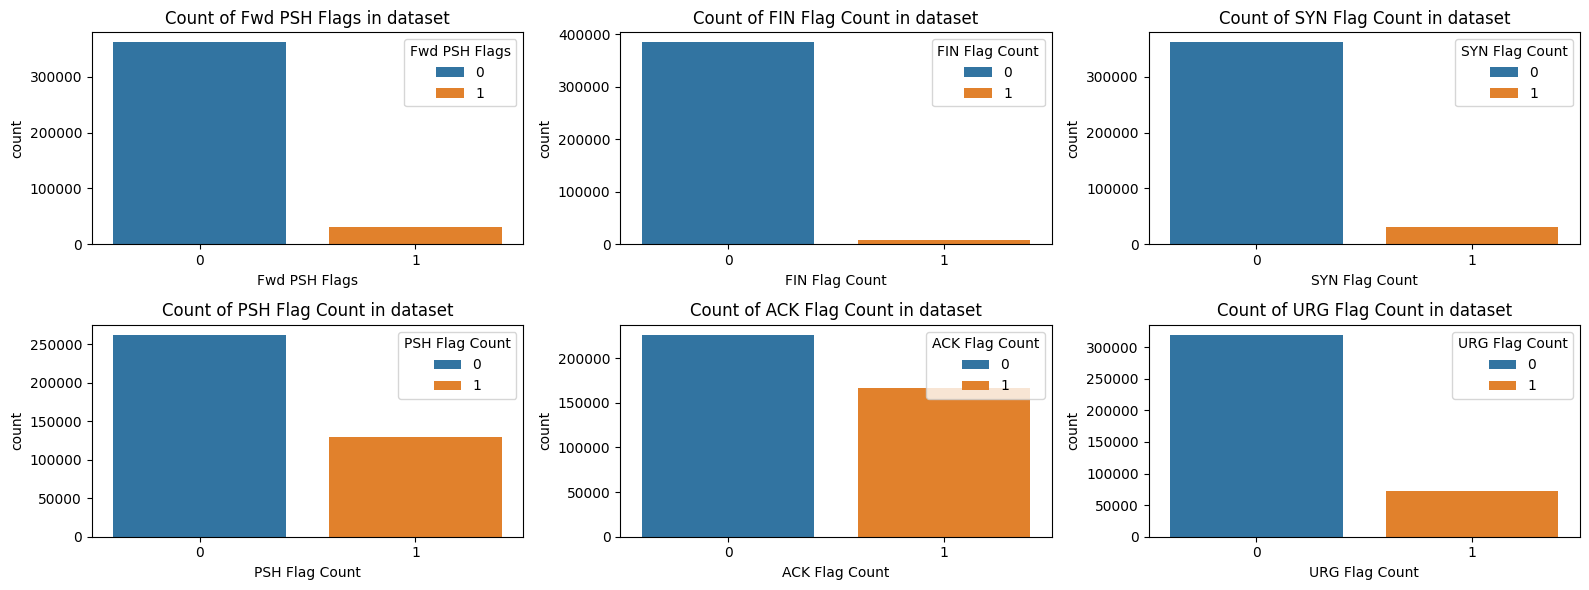

In [69]:
double_valued_cols = summary_df.loc[summary_df['Total Distinct'] == 2, 'Column'].tolist()
if 'Source_IP_type' in double_valued_cols:
    double_valued_cols.remove('Source_IP_type')
print(double_valued_cols)

num_cols = 3
num_rows = (len(double_valued_cols) + num_cols - 1) // num_cols

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 6), squeeze=False)

# Plot each column in double_valued_cols
for i, col in enumerate(double_valued_cols):
    row, col_index = divmod(i, num_cols)  # Determine row and column position
    sns.countplot(data=processed_ransomware_df, x=col, ax=axes[row, col_index], hue=col)
    axes[row, col_index].set_title(f'Count of {col} in dataset')

# Hide any unused subplots
for j in range(i + 1, num_rows * num_cols):
    row, col_index = divmod(j, num_cols)
    axes[row, col_index].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()


In [70]:
def calculate_cramer_matrix(df, categorical_cols=[], exclude_pairs=[]) :


  cramers_v_matrix = pd.DataFrame(index=categorical_cols, columns=categorical_cols)

  # Calculate Cramér's V only for upper triangular matrix
  for i, col1 in enumerate(categorical_cols):
      for j, col2 in enumerate(categorical_cols):
          if j == i :
            cramers_v_matrix.loc[col1, col2] = 1.0
          elif j > i:  # Only compute for upper triangular part
              # Skip calculation if the pair is in exclude_pairs
              if {col1, col2} in exclude_pairs :
                  cramers_v_matrix.loc[col1, col2] = np.NaN  # Mark as NaN or None if excluded
              else:
                  cramers_v_matrix.loc[col1, col2] = cramers_v(df[col1], df[col2])  # Calculate Cramér's V
              cramers_v_matrix.loc[col2, col1] = cramers_v_matrix.loc[col1, col2]  # Mirror value

  # Fill diagonal with 1.0 (self-correlation)
  # for col in categorical_cols:
  #     cramers_v_matrix.loc[col, col] = 1.0

  # Convert matrix to numeric type for heatmap compatibility
  cramers_v_matrix = cramers_v_matrix.astype(float)
  return cramers_v_matrix




In [72]:
  # Plot the heatmap

# categorical_cols = ['Label','Source_IP_type', 'Destination_IP_type','Source Port','Destination Port', 'Protocol',  'Fwd PSH Flags', 'SYN Flag Count', 'PSH Flag Count' , 'ACK Flag Count', 'URG Flag Count']
categorical_cols = ['Label','Source_IP_type', 'Destination_IP_type','Source Port','Destination Port'] # 'Protocol',  'Fwd PSH Flags', 'SYN Flag Count', 'PSH Flag Count' , 'ACK Flag Count', 'URG Flag Count']

exclude_pairs = [{'Source Port', 'Destination Port'}]

cramers_matrix = calculate_cramer_matrix(processed_ransomware_df, categorical_cols, exclude_pairs)
plt.figure(figsize=(10, 8))
sns.heatmap(cramers_matrix, annot=True, cmap="coolwarm")
plt.title("Cramér's V Heatmap for Categorical Columns")
plt.show()


KeyboardInterrupt: 

In [ ]:


# numerical_cols = [item for item in processed_ransomware_df if item not in categorical_cols]
# numerical_cols.remove('Timestamp')
# # print(numerical_cols)
# print (numerical_cols)
# #'winter':'blue', 'fall': 'red', 'spring':'orange', 'summer':'green'
# # data_df = day_df[numerical + ['season']]
# # data_df['season'] = data_df['season'].map({1: 'winter', 2: 'spring', 3: 'summer', 4: 'fall'})
# g =sns.pairplot(processed_ransomware_df, vars=numerical_cols, diag_kind='auto', hue= 'Label',kind = 'reg',palette = ransomware_palette, corner=True)
# g.fig.suptitle("Numerical Features RelationShip With Season")
# plt.show()

In [ ]:

# Ransomware labels
ransomware_labels = [
    'Benign', 'Charger', 'Jisut', 'Koler', 'Lockerpin', 'Pletor',
    'PornDroid', 'RansomBO', 'Simplocker', 'SVpeng', 'WannaLocker'
]

# Define a pastel color palette function
def make_pastel(color):
    rgb = mcolors.to_rgb(color)
    return [(0.5 + 0.5 * c) for c in rgb]

# Generate the pastel color palette dictionary
base_colors = [
    'blue', 'orange', 'green', 'purple', 'red', 'brown',
    'pink', 'gray', 'olive', 'cyan', 'magenta'
]
pastel_palette = {label: mcolors.to_hex(make_pastel(color)) for label, color in zip(ransomware_labels, base_colors)}

# Sample Data
np.random.seed(42)
n = 10000
processed_ransomware_df = pd.DataFrame({
    'Flow Duration': np.random.exponential(scale=1000, size=n),
    'Label': np.random.choice(ransomware_labels, size=n)
})

# Create scatter plots per label using pastel colors
scatter_plots = []
for label in ransomware_labels:
    subset = processed_ransomware_df[processed_ransomware_df['Label'] == label]
    points = hv.Points(subset, kdims=['Flow Duration'], vdims=['Label'])
    shaded = datashade(points, color_key={label: pastel_palette[label]}, width=600, height=400)
    scatter_plots.append(shaded)

# Overlay the scatter plots
hue_scatter_plot = hv.Overlay(scatter_plots).opts(
    title="Flow Duration by Type of Ransomware",
    xlabel="Flow Duration",
    ylabel="Frequency"
)

# Display the plot
hue_scatter_plot

In [ ]:
# fig, axes = plt.subplots(2, 1, figsize=(16, 6))
# sns.swarmplot(data=processed_ransomware_df, x='Label', y= 'Flow Duration', hue = 'Label', ax = axes[0], palette=ransomware_palette)
# axes[0].set_title('Flow Duration V Ransomware Types in dataset')
# axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)

# sns.violinplot(data=processed_ransomware_df, x='Label', y ='Flow Duration', ax = axes[1], hue='Label', palette=ransomware_palette)
# axes[1].set_title('Flow Duration V Ransomware Types in dataset')
# axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
# plt.show()